X shape before reshape: torch.Size([1024, 3600])
Number of parameters: 113570
Memory size: 454280 bytes
Epoch: 1 | train_loss: 2.7163 | train_acc: 0.1441 | test_loss: 2.8286 | test_acc: 0.0439
Epoch: 2 | train_loss: 2.4011 | train_acc: 0.2735 | test_loss: 2.7898 | test_acc: 0.1756
Epoch: 3 | train_loss: 2.1852 | train_acc: 0.3578 | test_loss: 2.2779 | test_acc: 0.3561
Epoch: 4 | train_loss: 1.9966 | train_acc: 0.4359 | test_loss: 1.9842 | test_acc: 0.4390
Epoch: 5 | train_loss: 1.8571 | train_acc: 0.5226 | test_loss: 1.8961 | test_acc: 0.5707
Epoch: 6 | train_loss: 1.7962 | train_acc: 0.5348 | test_loss: 1.6556 | test_acc: 0.6146
Epoch: 7 | train_loss: 1.6572 | train_acc: 0.5873 | test_loss: 1.6299 | test_acc: 0.5854
Epoch: 8 | train_loss: 1.5949 | train_acc: 0.6484 | test_loss: 1.5506 | test_acc: 0.7024
Epoch: 9 | train_loss: 1.5323 | train_acc: 0.6520 | test_loss: 1.5276 | test_acc: 0.6829
Epoch: 10 | train_loss: 1.3973 | train_acc: 0.7241 | test_loss: 1.5293 | test_acc: 0.6927
Epoch

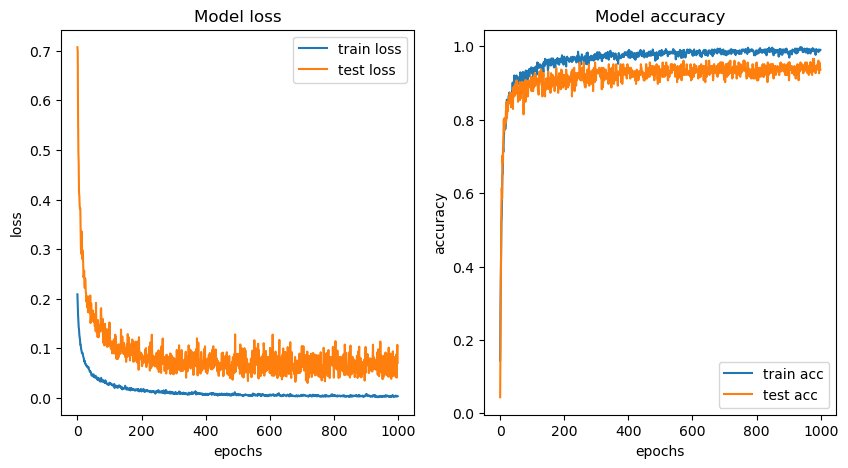

In [1]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from My_Basic_Net.utils.plot import plot_cfm
from My_Basic_Net.utils.OP_XNOR_NET1 import Bn_bin_conv_pool, WeightOperation, save_model
from My_Basic_Net.utils.Dataprocess import Loader
from My_Basic_Net.utils.engine import train,create_writer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 64
classes_num = 17
seed = 110
def set_seed(seed):
    # random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(seed)

lr = 0.01
epochs = 1000

class ECG_Bin(nn.Module):
    def __init__(self, device):
        super(ECG_Bin, self).__init__()
        self.name = 'Bin_ECG'
        self.device = device
        padding = 5
        pool_size = 5
        self.classifier = nn.Sequential(
        # input_channels, output_channels, kernel_size:335733, stride, padding7, pad_value, pool_size5, pool_stride
            Bn_bin_conv_pool( 1, 8, 11, 1, padding, 1,
                            pool_size, 2),
            Bn_bin_conv_pool( 8, 16, 11, 1, padding, 1,
                              pool_size, 2),
            Bn_bin_conv_pool( 16, 32, 11, 1, padding, 1,
                              pool_size, 2),
            Bn_bin_conv_pool(32, 64, 11, 1, padding, 1,
                             pool_size, 2),# 加一层
            Bn_bin_conv_pool( 64, 72, 11, 1, padding, 1,
                              pool_size, 2),
            Bn_bin_conv_pool(72, 32, 9, 1, padding, 1,
                             pool_size, 2),
            Bn_bin_conv_pool(32, 32, 9, 1, padding, 1,
                             pool_size, 2),
            Bn_bin_conv_pool( 32, classes_num, 5, 1, padding, 1,
                              pool_size, 2)

        )
        self.dropout = nn.Dropout(p=0.5) # 防止过拟合
        # self.flatten = nn.Flatten()
        # self.linear1 = BinLinear(in_features=1600, out_features=512)
        # self.linear2 = BinLinear(in_features=512, out_features=17)
    def forward(self, batch_data):
        # print('batch_data.shape: ', batch_data.shape)  # [32, 1, 3600]
        batch_data = batch_data.clone().detach().requires_grad_(True).to(self.device)

        batch_data = self.classifier(batch_data)
        # print('000000: ', batch_data.shape)  # [32, 17, 64]
        # batch_data = self.out(batch_data)
        # batch_data = self.flatten(batch_data)
        # batch_data = self.linear1(batch_data)
        # batch_data = self.linear2(batch_data)
        batch_data = self.dropout(batch_data)
        batch_data = batch_data.mean(dim=2)  # 去掉一个维度

        return batch_data

loader = Loader(batch_size=batch_size, classes_num=classes_num, device=device, test_size=0.2)
labels, train_loader, test_loader = loader.loader()

# model = ECG_XNOR()
model = ECG_Bin(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memory size: {sum(p.numel() * p.element_size() for p in model.parameters())} bytes")
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())
# adjust_learning_rate (optimizer, epochs)
# lr_scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,epochs,1,0.02)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.05,last_epoch=-1)

weightOP = WeightOperation(model)

# Make sure model on target device
model.to(device)

train(model=model,
      train_dataloader=train_loader,
      test_dataloader=test_loader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      device=device,
      # writer=create_writer(experiment_name='11.5.xnor_exp_3kepoch_1th',
      #                      model_name=model.name,
      #                      extra=f"{epochs}_epochs"),
      weight_op = weightOP)
# save_filepath = f"11.04_{model.name}_{epochs}_epochs.pth"
# save_model(model=model,
#            target_dir="models",
#            model_name=save_filepath)
print("-" * 50 + "\n")

the model accuracy is  0.9365853658536586
+-----------+-------+-------+-------+-------+-------+
|           |  ACC  |  SEN  |  SPE  |  PPR  |   F1  |
+-----------+-------+-------+-------+-------+-------+
|    NSR    | 0.951 | 0.983 | 0.939 | 0.864 | 0.919 |
|    APB    | 0.985 |  0.8  |  1.0  |  1.0  | 0.889 |
|    AFL    | 0.995 |  1.0  | 0.995 |  0.8  | 0.889 |
|    AFIB   | 0.985 |  0.9  |  1.0  |  1.0  | 0.947 |
|    SVTA   |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
|    WPW    |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
|    PVC    | 0.961 | 0.815 | 0.983 |  0.88 | 0.846 |
|  Bigeminy |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
| Trigeminy |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
|     VT    |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
|    IVR    |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
|    VFL    |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
|   Fusion  |  1.0  |  1.0  |  1.0  |  1.0  |  1.0  |
|   LBBBB   | 0.995 | 0.929 |  1.0  |  1.0  | 0.963 |
|   RBBBB   |  1.0  |  1.0  |  1.0  |  1

<Figure size 640x480 with 0 Axes>

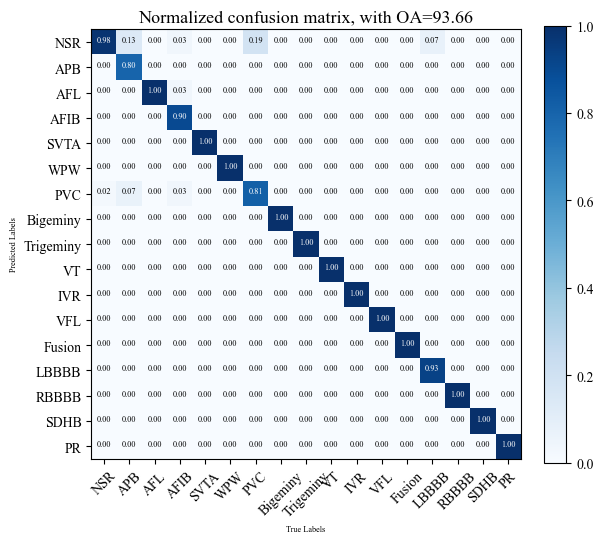

In [2]:
plot_cfm(model, test_loader, classes=labels, mode='full_net1', cnt=1000, clt=classes_num)